In [50]:
import gc
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from tqdm import tqdm

In [31]:
'''DATASETS'''
root = r"E:\DATASETS\UNZIP_datasets\data_kaggle\vesuvius-challenge-ink-detection"
train_path = root+'/train'
train1 = root+'/train/1'
surface_volume = train1 + '/surface_volume'
'''
1,2,3 train's surface_volume number is 64
deal 1 first and the other the same
'''

"\n1,2,3 train's surface_volume number is 64\ndeal 1 first and the other the same\n"

In [32]:
def make_group(ls,start,group_num=10, step=1):
    group = []
    idx = start
    while group_num:
        group.append(ls[idx])
        group_num -= 1
        idx = (idx + step)%len(ls)
    return group



In [33]:
def make_sorted_list(train_path,group_len=10, sets="1", step=1):
    groups = []
    path = train_path + os.sep + sets +"/surface_volume"
    path = Path(path)
    files = sorted([f for f in path.iterdir()])
    end = len(files)-1
    for i in range(end):
        groups.append(make_group(files, i, group_len, step))
    return groups

In [47]:
# 将一组group合成(b, c=10, h, w) 
def make_one_img(group):
    gp = list(map(lambda  img:np.array(Image.open(img)), group))
    return np.stack(gp, axis=0)

def make_datasets(train_path, groups, label="1"):
    lable_path = train_path + os.sep + str(label) + os.sep + "inklabels.png"
    label = np.array(Image.open(lable_path))

    for group in groups:
        img = make_one_img(group)
        img = img[np.newaxis, :]
        yield (img, label)

In [35]:
gc.collect()

0

In [48]:
# make 1, 2, 3 datasets
groups1 = make_sorted_list(train_path, 10, "1", 2)
groups2 = make_sorted_list(train_path, 10, "2", 2)
groups3 = make_sorted_list(train_path, 10, "3", 2)

ds1 = make_datasets(train_path, groups1, "1")
ds2 = make_datasets(train_path, groups2, "2")
ds3 = make_datasets(train_path, groups3, "3")

print(next(iter(ds1))[0].shape)
print(next(iter(ds1))[1].shape)


(1, 10, 8181, 6330)
(8181, 6330)


In [45]:
# show ds
def show_img_label(ds):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(ds[0][0])    # 0.1 img not the whole img
    ax1.set_title("img")
    ax1.axis("off")
    ax2.imshow(ds[1])
    ax2.set_title("label")
    ax2.axis("off")

<Figure size 640x480 with 0 Axes>

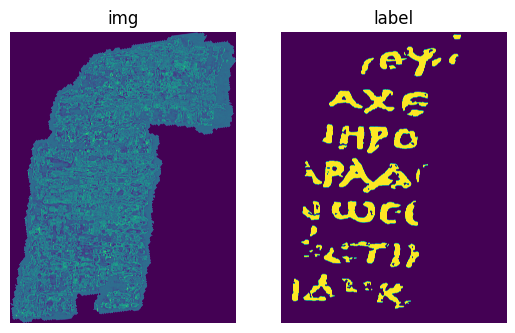

In [46]:
show_img_label(next(iter(ds1)))

C:\Users\zy\anaconda3\envs\kaggle_tch\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

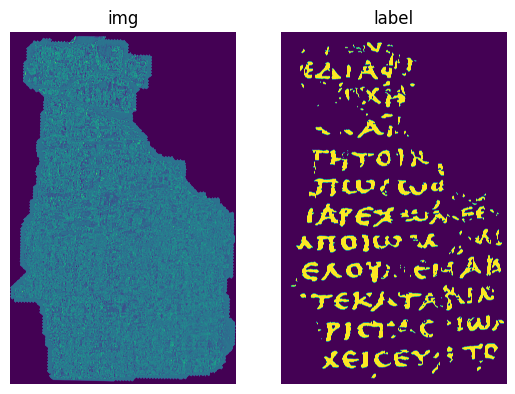

In [69]:
show_img_label(next(iter(ds2)))

<Figure size 640x480 with 0 Axes>

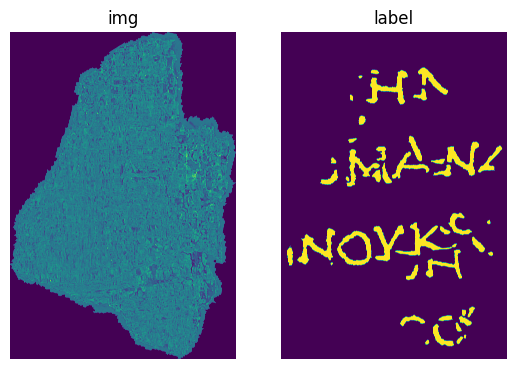

In [70]:
show_img_label(next(iter(ds3)))

In [72]:
gc.collect()

11589

In [ ]:
datasets = []
for i, ds in enumerate([ds1, ds2, ds3]):
    print(f"datasets{i}:")
    for img_label in tqdm(ds):
        datasets.append(img_label)

datasets0:


14it [04:52, 63.13s/it]

In [ ]:
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img = self.dataset[index][0]    # (10, H, W)
        msk = self.dataset[index][1]    # (H, W)

        if self.transform:
            data = self.transform(image=img, mask=msk)
            img = data['image']
            msk = data['mask']
            # mask_c = mask.cpu().numpy()
        else:
            img = img
            msk = msk
        img = np.transpose(img, (2, 0, 1))
        return img, msk

    def __len__(self):
        return len(self.dataset)